In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
scratch = "/pscratch/sd/t/timothys"

In [4]:
varnames = [
    "surface_pressure",
    "10m_zonal_wind",
    "10m_meridional_wind",
    "2m_temperature",
    "500hpa_geopotential_height",
    "250hpa_zonal_wind",
    "250hpa_meridional_wind",
    "850hpa_temperature",
    "850hpa_specific_humidity",
]

In [53]:
metric = "MAE"
rmse = {}

rmse["Nested-EAGLE 0.25\u00B0/06km"] = xr.Dataset({
    varname: xr.load_dataset(f"{scratch}/nested-eagle/0.25deg-06km/mse06h/experiments/1.0deg-24km-latent/1x16encoders/inference-validation/obs-val/{varname}.nc")[metric]
    for varname in varnames
})

## Single Initial Condition Coarse Model
#rmse["Nested-EAGLE 1.00\u00B0/15km"] = xr.Dataset({
#    varname: xr.load_dataset(f"{scratch}/nested-eagle/1.00deg-15km/mse06h/experiments/nic/sic/inference-validation/obs-val/{varname}.nc")[metric]
#    for varname in varnames
#})

## Two IC Coarse Model
#rmse["Nested-EAGLE 1.00\u00B0/15km"] = xr.Dataset({
#    varname: xr.load_dataset(f"{scratch}/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/inference-validation/obs-val/{varname}.nc")[metric]
#    for varname in varnames
#})

rmse["HRRR 06km"] = xr.Dataset({
    varname: xr.load_dataset(f"{scratch}/nested-eagle/0.25deg-06km/baselines/hrrr-forecasts-vs-hrrr-analysis/trim25/obs-val/{varname}.nc")[metric]
    for varname in varnames
})

#rmse["HRRR 15km"] = xr.Dataset({
#    varname: xr.load_dataset(f"{scratch}/nested-eagle/1.00deg-15km/baselines/hrrr-forecasts-vs-hrrr-analysis/trim10/obs-val/{varname}.nc")[metric]
#    for varname in varnames
#})

rmse["GFS 0.25\u00b0"] = xr.Dataset({
    varname: xr.load_dataset(f"{scratch}/nested-eagle/0.25deg-06km/baselines/gfs-forecasts-vs-hrrr-analysis/trim25/obs-val/{varname}.nc")[metric]
    for varname in varnames
})

#rmse["GFS 1.00\u00b0"] = xr.Dataset({
#    varname: xr.load_dataset(f"{scratch}/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-hrrr-analysis/trim10/obs-val/{varname}.nc")[metric]
#    for varname in varnames
#})

#rmse["GEFS Ensemble Mean"] = xr.Dataset({
#    varname: xr.load_dataset(f"{scratch}/nested-eagle/1.00deg-15km/baselines/gefs-ensemble-mean-vs-hrrr-analysis/obs-val/{varname}.nc")[metric]
#    for varname in varnames
#})
#rmse["HRRR 3km"] = xr.Dataset({
#    varname: xr.load_dataset(f"{scratch}/nested-eagle/native/baselines/hrrr-forecasts/obs-val/{varname}.nc")[metric]
#    for varname in varnames
#})

In [54]:
prefix = ""
if "Nested-EAGLE 1.00\u00B0/15km" in rmse or "Nested-EAGLE 1.00\u00B0/15km - sic" in rmse:
    prefix = "allres_"

print(prefix)

In [55]:
nice_names = {
    "surface_pressure": "Surface Pressure (Pa)",
    "2m_temperature": "2m Temperature (\u00B0C)",
    "10m_zonal_wind": "10m Zonal Wind (m s$^{-1}$)",
    "10m_meridional_wind": "10m Meridional Wind (m s$^{-1}$)",
    "500hpa_geopotential_height": "500 hPa Geopotential Height (m)",
    "850hpa_temperature": "850 hPa Temperature (\u00B0C)",
    "850hpa_specific_humidity": "850 hPa Specific Humidity (kg kg$^{-1}$)",
    "250hpa_zonal_wind": "250 hPa Zonal Wind (m s$^{-1}$)",
    "250hpa_meridional_wind": "250 hPa Meridional Wind (m s$^{-1}$)",
}

In [56]:
def single_plot(ax, dsdict, varname, sel=None, **kwargs):
    for label, xds in dsdict.items():
        plotme = xds[varname] if sel is None else xds[varname].sel(**sel)
        df = plotme.to_dataframe().reset_index()
        linestyle = "-"
        if "Nested" in label:
            color = "C0"
            if "15km" in label:
                linestyle = ":"
        elif "HRRR" in label:
            color = "C1"
            if "15km" in label:
                linestyle = ":"
        elif "GFS" in label:
            color = "C2"
            if "1" in label:
                linestyle = ":"
                
        sns.lineplot(
            data=df,
            x="fhr",
            y=varname,
            ax=ax,
            label=label,
            color=color,
            linestyle=linestyle,
            legend=False,
            **kwargs,
        )
    dt = 24
    if sel is not None:
        if sel.get("fhr", None) is not None:
            dt = 6
    last_time = 240 if dt == 24 else 48
    xticks = np.arange(0, last_time+1, dt)
    xticklabels = xticks//24 if dt == 24 else xticks #plotme.fhr.values
    units = "days" if dt == 24 else "hours"
    #xticks = xticks if len(xticks)<10 else np.concatenate([ [xticks[0]], xticks[4::4]])
    ax.text(.05, .9, nice_names[varname], transform=ax.transAxes, ha="left", va="center")
    ax.set(
        ylabel=metric.upper() if ax.get_subplotspec().is_first_col() else "",
        xlabel=f"Lead Time ({units})" if ax.get_subplotspec().is_last_row() else "",
        title="",#nice_names[varname],# if ax.get_subplotspec().is_first_row() else "",
        xticks=xticks,
        xticklabels=xticklabels,
    )
    #ax.legend(frameon=False)

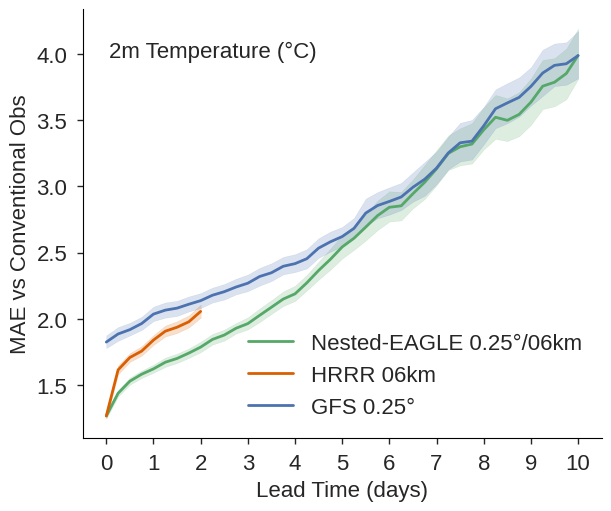

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True, sharex=True)
    
single_plot(ax=ax, dsdict=rmse, varname="2m_temperature")
handles, labels = ax.get_legend_handles_labels()
ax.set(ylabel=f"{metric} vs Conventional Obs")
if "allres" in prefix:
    fig.legend(handles, labels, bbox_to_anchor=(1., .6), loc='center left', fontsize='large', frameon=False)
else:
    ax.legend(frameon=False, loc="lower right")
fig.savefig(f"figures/{prefix}t2m_{metric.lower()}_vs_obs.jpeg", bbox_inches="tight", dpi=300)

/tmp/ipykernel_1383862/1387610111.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])


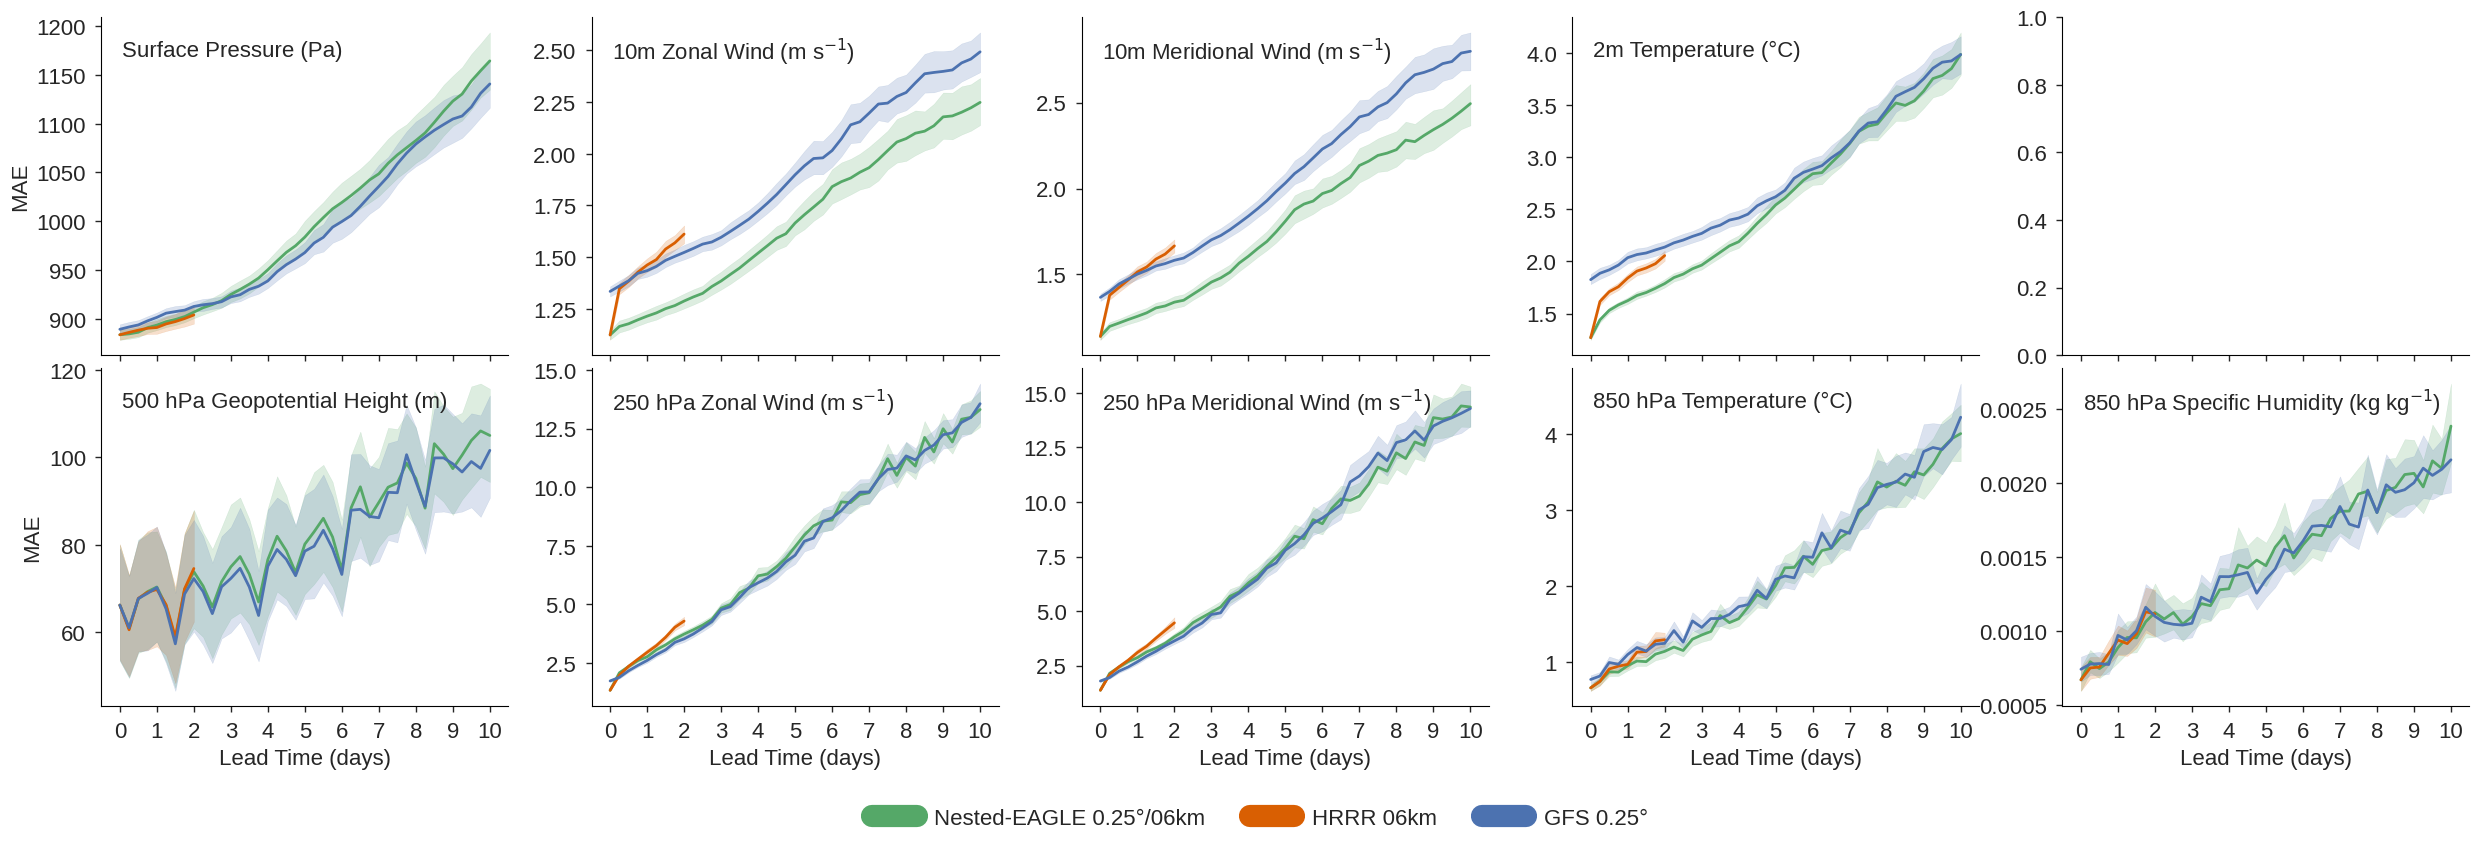

In [58]:
nvars = len(varnames)
nrows = 2
ncols = np.ceil(nvars / nrows).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), constrained_layout=True, sharex=True)
    
for varname, ax in zip(varnames[:4], axs.flatten()):
    single_plot(ax=ax, dsdict=rmse, varname=varname)
for varname, ax in zip(varnames[-5:], axs.flatten()[-5:]):
    single_plot(ax=ax, dsdict=rmse, varname=varname)
handles, labels = axs[0, 0].get_legend_handles_labels()
legend = fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncols=len(labels),
    frameon=False,
)
for line in legend.get_lines():
    line.set_linewidth(16)
plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])
#fig.legend(handles, labels, bbox_to_anchor=(1., .6), loc='center left', fontsize='large', frameon=False)
fig.savefig(f"figures/{prefix}{metric.lower()}_vs_obs.jpeg", bbox_inches="tight", dpi=300)

/tmp/ipykernel_1383862/2384225268.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])


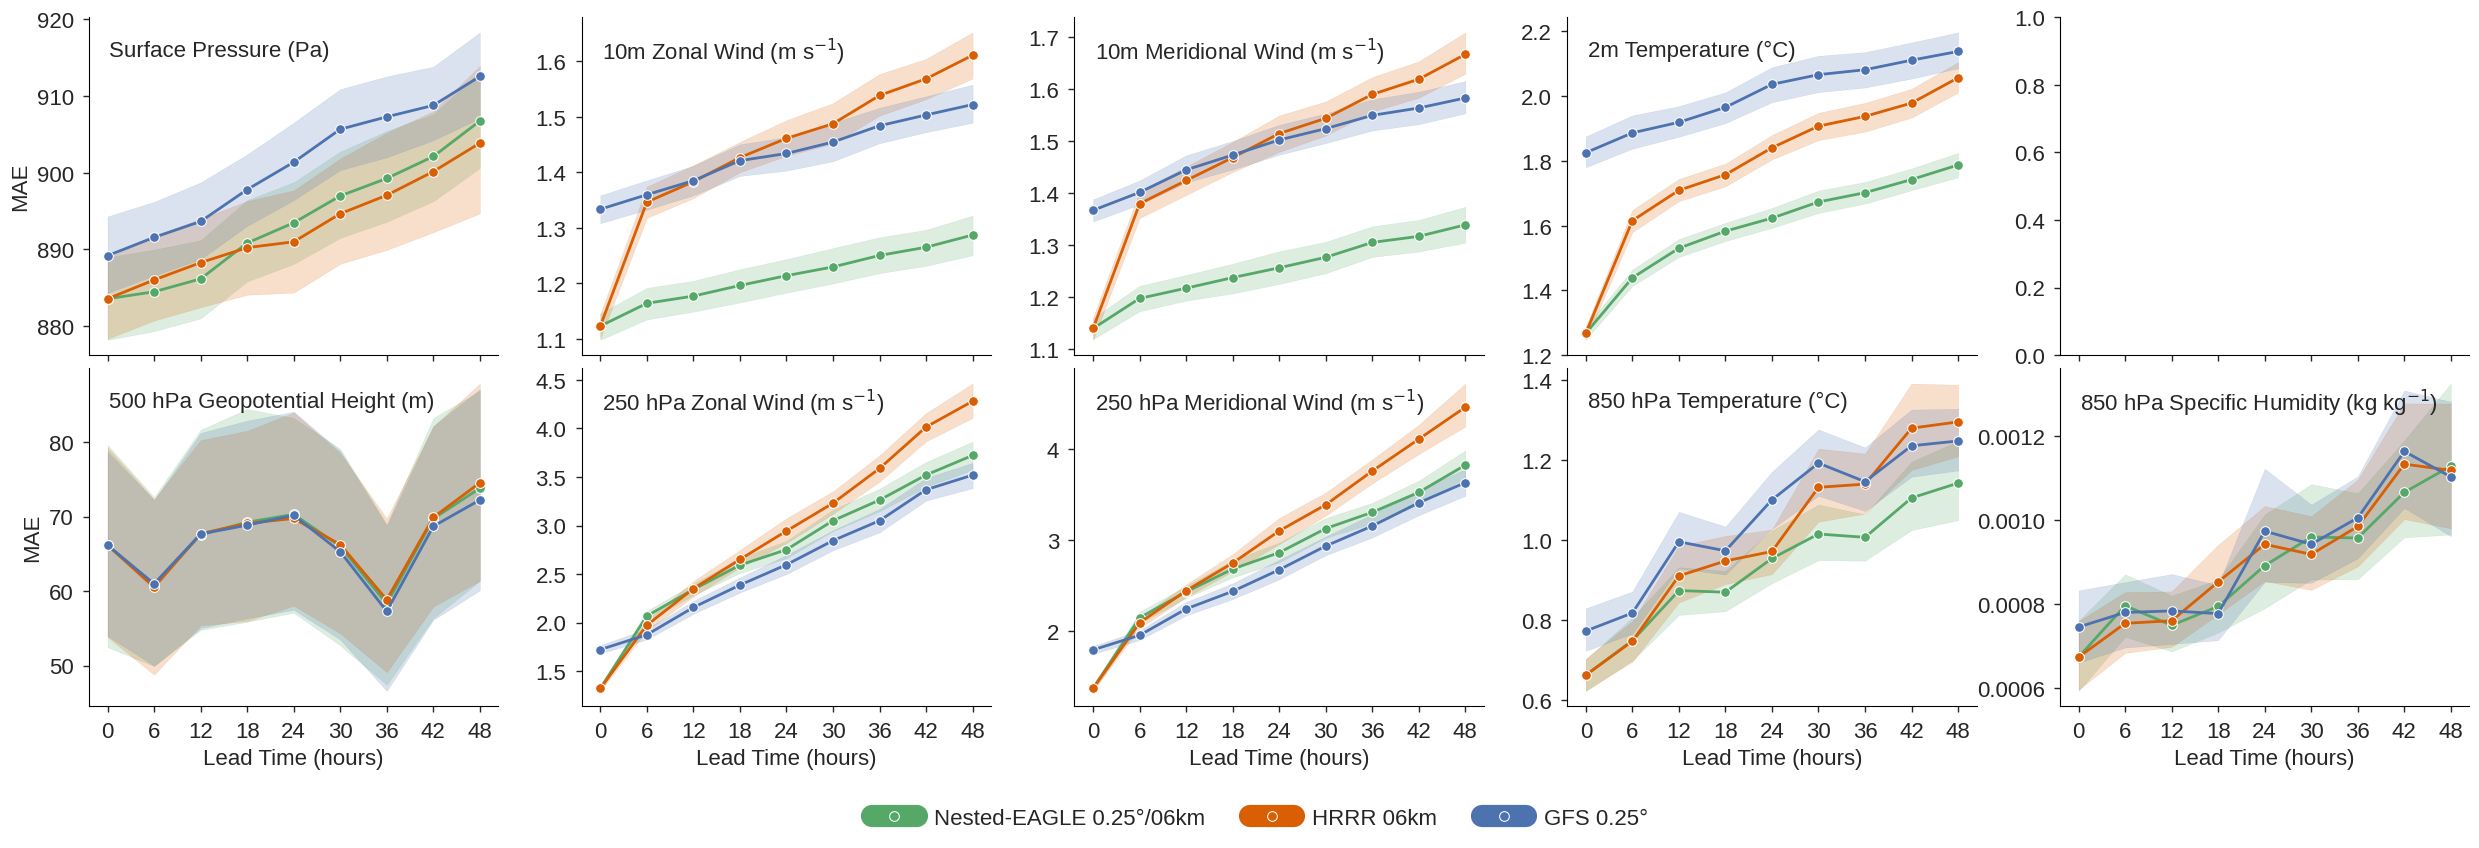

In [59]:
nvars = len(varnames)
nrows = 2
ncols = np.ceil(nvars / nrows).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), constrained_layout=True, sharex=True)
    
for varname, ax in zip(varnames[:4], axs.flatten()[:4]):
    single_plot(ax=ax, dsdict=rmse, varname=varname, sel={"fhr": slice(49)}, marker="o")
for varname, ax in zip(varnames[-5:], axs.flatten()[-5:]):
    single_plot(ax=ax, dsdict=rmse, varname=varname, sel={"fhr": slice(49)}, marker="o")
handles, labels = axs[0, 0].get_legend_handles_labels()
legend = fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncols=len(labels),
    frameon=False,
)
for line in legend.get_lines():
    line.set_linewidth(16)
plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])
fig.savefig(f"figures/{prefix}{metric.lower()}_vs_obs_48h.jpeg", bbox_inches="tight", dpi=300)